In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt
from PIL import Image as img
import numpy as np

#tf, keras imports
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from clf import get_clf

#suppress warnings
import warnings
warnings.simplefilter('ignore')

import cv2
import gc
import random
from sklearn.utils import shuffle


### Data labels 

In [1]:
file = 'HASYv2/hasy-data-labels.csv'
df = pd.read_csv(file)

NameError: name 'pd' is not defined

### Symbols 

In [10]:
sym_file = 'HASYv2/symbols.csv'
symbols = pd.read_csv(sym_file)

## Subset of data: digits only

In [11]:
digits = df[(df['symbol_id']<=79) & (df['symbol_id']>=70)]
# digits 0-9
#symbols.iloc[27:37]

In [12]:
# digits
# #Display imgs
# for x in digits.path:
#     print('HASYv2/'+x)
#     display(Image(filename='HASYv2/'+x))

# Make pixel arrays

In [13]:
def make_pixel_array(df):
    im = img.open('HASYv2/'+df['path'],'r').convert('L')
    return np.asarray(im)  ##255-val inverts colors

In [14]:
digits['pixels']=digits.apply(make_pixel_array,axis=1)

# Process image

In [176]:
nrows = 28
ncolumns = 28
channels = 1
def read_process_images(img_list,y,invert=False):
    img_list,y = shuffle(img_list,y)
    y = [int(label) for label in y]
    X=[]
    for path in img_list:
        image = 'HASYv2/' + path       ##can do color .IMREAD_COLOR
        X.append(cv2.resize(cv2.imread(image,cv2.IMREAD_GRAYSCALE),(nrows,ncolumns),interpolation=cv2.INTER_CUBIC))
    if invert==True:
        return 255-np.array(X),np.array(y)
    return np.array(X),np.array(y)

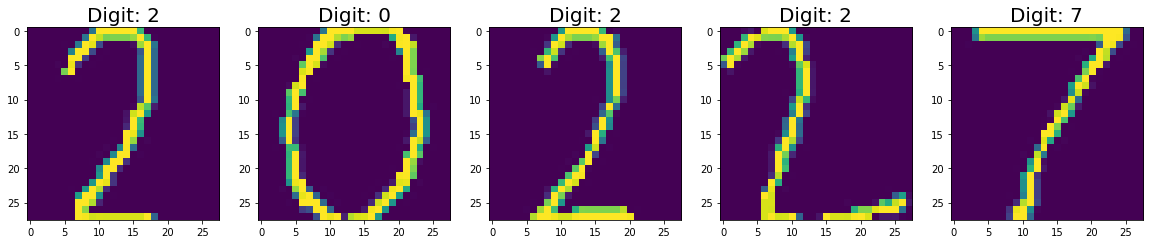

In [178]:
X,y = read_process_images(digits['path'],digits['latex'],invert=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
ntrain = len(X_train)
ntest = len(X_test)
batch_size = 32

plt.figure(figsize=(20,10))
cols = 5
for i in range(cols):
    plt.subplot(5/cols+1,cols,i+1)
    plt.imshow(X[i])
    plt.title('Digit: '+str(y[i]),fontsize=20)

gc.collect();

In [121]:
model = models.Sequential()  #stack layers sequentially
model.add(layers.Conv2D(batch_size,(3,3),activation='relu',input_shape=(nrows,ncolumns,channels)))
model.add(layers.MaxPooling2D((2,2)))
for i in [64,128]:
    model.add(layers.Conv2D(i,(3,3),activation='sigmoid',input_shape=(nrows,ncolumns,channels)))
    model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [122]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

In [123]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

In [124]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_test,y_test,batch_size=batch_size)

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch = ntrain//batch_size,
                             epochs = 64, validation_data = val_generator, validation_steps=ntest//batch_size)

# HaSYv2 Dataset

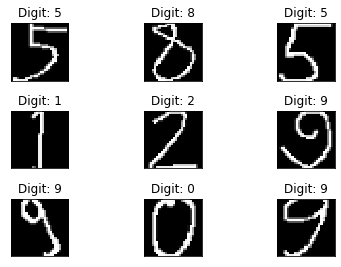

In [181]:
X,y = read_process_images(digits['path'],digits['latex'],invert=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i],cmap='gray',interpolation='none')
    plt.title('Digit: {}'.format(y_train[i]))
    plt.xticks([])
    plt.yticks([])


In [182]:
clf = DecisionTreeClassifier()
clf.fit(X_train.flatten().reshape(len(X_train), -1), y_train)
y_predict_hasy = clf.predict(X_test.flatten().reshape(len(X_test), -1))

In [183]:
print(accuracy_score(y_test,y_predict_hasy))

0.5735294117647058


# MNIST Dataset

In [2]:
(X_tr,y_tr),(X_ts,y_ts) = mnist.load_data()

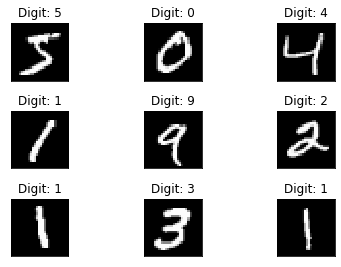

In [3]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_tr[i],cmap='gray',interpolation='none')
    plt.title('Digit: {}'.format(y_tr[i]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_tr.flatten().reshape(len(X_tr), -1), y_tr)
yhat = clf.predict(X_ts.flatten().reshape(len(X_ts), -1))

In [60]:
print(accuracy_score(y_ts,yhat))

0.8772


array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [131]:
y_tr.shape

(60000,)

# Join MNIST and HaSYv2 Datasets

In [184]:
X_JOINED = np.concatenate((X_tr, X,X_ts), axis=0)

In [185]:
y_JOINED = np.concatenate((y_tr, y,y_ts), axis=0)

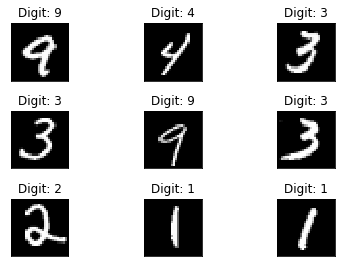

In [186]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_JOINED, y_JOINED, train_size=.8)
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train1[i],cmap='gray',interpolation='none')
    plt.title('Digit: {}'.format(y_train1[i]))
    plt.xticks([])
    plt.yticks([])


In [254]:
get_clf(X_train1, X_test1, y_train1, y_test1)[1]

0.8713038580681498

# INKml to png conversion

In [3]:
import inkml.inkml2img as conv
import subprocess
import os

In [4]:
ink_files = []
f = os.popen("ls INKdata/trainData_2012_part1/*.inkml")
for i in f.readlines():
    ink_files.append(i[:-1])
f.close()    

In [255]:
!ls train2012_png/

TrainData1_8_sub_12.png   TrainData2_17_sub_88.png  TrainData2_25_sub_9.png
TrainData1_8_sub_15.png   TrainData2_17_sub_95.png  TrainData2_26_sub_11.png
TrainData1_8_sub_19.png   TrainData2_17_sub_98.png  TrainData2_26_sub_13.png
TrainData1_8_sub_21.png   TrainData2_17_sub_9.png   TrainData2_26_sub_15.png
TrainData1_8_sub_24.png   TrainData2_18_sub_11.png  TrainData2_26_sub_17.png
TrainData1_8_sub_28.png   TrainData2_18_sub_13.png  TrainData2_26_sub_1.png
TrainData1_8_sub_9.png	  TrainData2_18_sub_15.png  TrainData2_26_sub_20.png
TrainData2_0_sub_11.png   TrainData2_18_sub_17.png  TrainData2_26_sub_29.png
TrainData2_0_sub_13.png   TrainData2_18_sub_1.png   TrainData2_26_sub_33.png
TrainData2_0_sub_15.png   TrainData2_18_sub_20.png  TrainData2_26_sub_39.png
TrainData2_0_sub_17.png   TrainData2_18_sub_29.png  TrainData2_26_sub_41.png
TrainData2_0_sub_1.png	  TrainData2_18_sub_33.png  TrainData2_26_sub_43.png
TrainData2_0_sub_20.png   TrainData2_18_sub_39.png  TrainData2_26_sub_46.png
Tra

In [5]:
from skimage import io
from skimage import filters, color
from scipy import ndimage as ndi


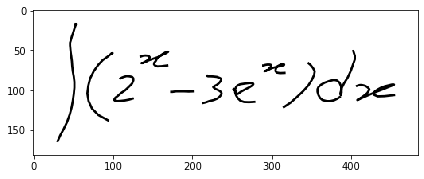

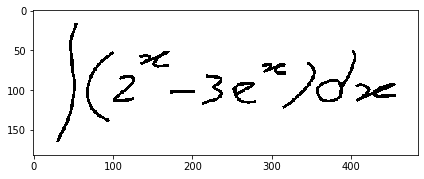

number of objects 11


In [6]:
digit = io.imread('train2012_png/TrainData2_2_sub_61.png')
io.imshow(digit)
io.show()
digit.ndim
gray_image = color.rgb2gray(digit)
thresh = filters.threshold_mean(gray_image)
binary_image = gray_image > thresh

io.imshow(binary_image)
io.show()
label_objects, nb_labels = ndi.label(np.invert(binary_image))
print("number of objects", nb_labels)

number of objects 11


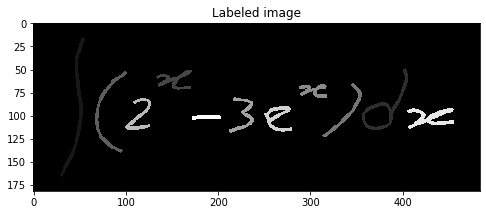

In [7]:
arr = np.array(label_objects)

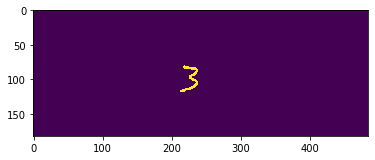

In [8]:

# fig,axes = plt.subplots(nb_labels,1,figsize=(20,7*nb_labels))
# for ax in axes.flatten():
#     for segment in range(1,nb_labels+1):
#         ax.imshow(arr==segment)
two = arr==8
three = arr==7
plt.imshow(three);

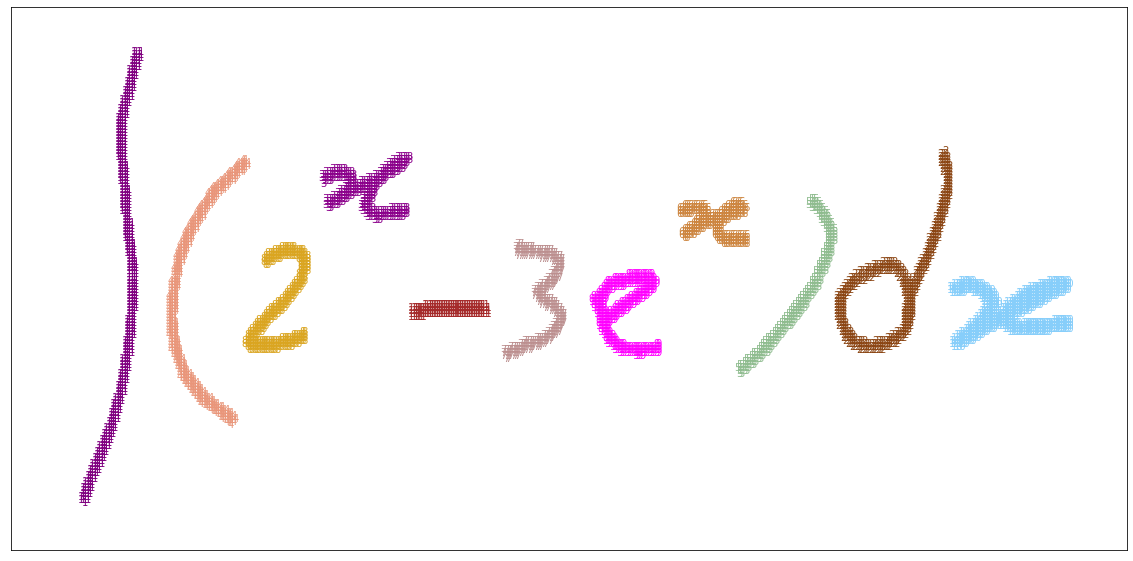

In [347]:
plt.rcParams["figure.figsize"] = (20,10)
pixarray=np.rot90(label_objects,3)
imax,jmax = pixarray.shape
plt.xticks(np.arange(0,imax))
plt.yticks(np.arange(0,jmax))
np.random.shuffle(colors)
ind = range(nb_labels)
for i in range(imax):
    for j in range(jmax):
        val = pixarray[i][j]
        if val != 0:
            plt.text(i,j,val,fontsize=10,color=colors[val])
plt.xticks([])
plt.yticks([])            
plt.show()


In [343]:
np.rot90(label_objects).shape

(484, 182)

In [332]:
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
from itertools import chain
colors = np.array(list(chain(mcolors.CSS4_COLORS.values())))

(182, 484)

In [8]:
three = arr==7
plt.imshow(three);

NameError: name 'arr' is not defined